## XGBoost Model for OSM Contributions Data

#### Positive Class (label = 1): Vandalism
#### Negative Class (label = 0): Not Vandalism

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd


### Create directories required for the code

In [3]:
import os

# Define the directory and file path for saving the model
save_dir = '../saved_parameters/contribution_model/'
model_file = os.path.join(save_dir, 'final_xgboost_model.pkl')

# Check if the directory exists, else create it
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    print(f"Directory created at: {save_dir}")
else:
    print(f"Directory already exists at: {save_dir}")

Directory already exists at: ../saved_parameters/contribution_model/


### Load the data set into a data frame

In [4]:
features_df = pd.read_parquet("../data/contribution_data/extracted_features_v3.parquet")

#Shuffle the data entries
features_df = features_df.sample(frac=1, random_state=42).reset_index(drop=True)
features_df.head()

,user_id,user_edit_frequency_7d,user_edit_frequency_14d,user_edit_frequency_30d,user_edit_frequency_60d,user_edit_frequency_180d,user_edit_frequency_365d,user_edit_frequency_all,editor_used,area_delta,...,emergency,geological,healthcare,highway,historic,landuse,leisure,man_made,military,vandalism
0,1020680,0.0,0.0,0.0,0.0,0.000000,0.000000,0,Level0 v1.2,1644,...,0,0,0,0,0,1,0,0,0,False
1,1075986,0.0,0.0,0.0,0.0,0.155556,0.076712,0,JOSM,117,...,0,0,0,0,0,0,0,0,0,True
2,246941,0.0,0.0,0.0,0.0,0.000000,0.000000,0,JOSM,0,...,0,0,0,0,0,0,0,0,0,False
3,3392,0.0,0.0,0.0,0.0,0.000000,1.739726,0,Potlatch 2,0,...,0,0,0,1,0,0,0,0,0,True
4,1942179,0.0,0.0,0.0,0.0,0.000000,0.000000,0,,0,...,0,0,0,0,0,0,0,0,0,True


### Drop unnecessary columns and replace spaces with underscores

In [5]:
if features_df.columns.__contains__('xzcode'):
    # Split 'xzcode' column into two separate columns 'code' and 'level'
    features_df[['code', 'level']] = pd.json_normalize(features_df['xzcode'])
    features_df.drop('xzcode', axis=1, inplace=True)

if features_df.columns.__contains__('geometry'):
    features_df.drop('geometry', axis=1, inplace=True)

if features_df.columns.__contains__('osm_id'):
    features_df.drop('osm_id', axis=1, inplace=True)

if features_df.columns.__contains__('members'):
    features_df.drop('members', axis=1, inplace=True)

if features_df.columns.__contains__('status'):
    features_df.drop('status', axis=1, inplace=True)

if features_df.columns.__contains__('editor_used'):
    features_df.drop('editor_used', axis=1, inplace=True)

features_df.columns = features_df.columns.str.replace(' ', '_', regex=True)

#TODO: Most of the features are very similar. especially all contribution under same changeset id. It might be potential reason for high accuracy. Check a way to handle that.

features_df.head()

,user_id,user_edit_frequency_7d,user_edit_frequency_14d,user_edit_frequency_30d,user_edit_frequency_60d,user_edit_frequency_180d,user_edit_frequency_365d,user_edit_frequency_all,area_delta,length_delta,...,healthcare,highway,historic,landuse,leisure,man_made,military,vandalism,code,level
0,1020680,0.0,0.0,0.0,0.0,0.000000,0.000000,0,1644,-216,...,0,0,0,1,0,0,0,False,5016864557,16
1,1075986,0.0,0.0,0.0,0.0,0.155556,0.076712,0,117,0,...,0,0,0,0,0,0,0,True,5014238182,16
2,246941,0.0,0.0,0.0,0.0,0.000000,0.000000,0,0,0,...,0,0,0,0,0,0,0,False,5011061704,16
3,3392,0.0,0.0,0.0,0.0,0.000000,1.739726,0,0,-205,...,0,1,0,0,0,0,0,True,3184713878,16
4,1942179,0.0,0.0,0.0,0.0,0.000000,0.000000,0,0,0,...,0,0,0,0,0,0,0,True,5020807494,16


In [6]:
contributions_with_changeset = features_df[features_df['changeset_id'] == 31867220]
# Print the resulting DataFrame
contributions_with_changeset.head()

,user_id,user_edit_frequency_7d,user_edit_frequency_14d,user_edit_frequency_30d,user_edit_frequency_60d,user_edit_frequency_180d,user_edit_frequency_365d,user_edit_frequency_all,area_delta,length_delta,...,healthcare,highway,historic,landuse,leisure,man_made,military,vandalism,code,level
222173,2977954,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,...,0,0,0,0,0,0,0,True,1142453926,16
292410,2977954,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,...,0,1,0,0,0,0,0,True,1142453917,14
364032,2977954,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,...,0,0,0,0,0,0,0,True,1142453926,16


In [7]:
features_df.columns

Index(['user_id', 'user_edit_frequency_7d', 'user_edit_frequency_14d',
       'user_edit_frequency_30d', 'user_edit_frequency_60d',
       'user_edit_frequency_180d', 'user_edit_frequency_365d',
       'user_edit_frequency_all', 'area_delta', 'length_delta', 'area',
       'length', 'bounding_box_size', 'geometry_valid', 'xmax', 'xmin', 'ymax',
       'ymin', 'time_since_last_edit', 'edit_time_of_day', 'tags_added',
       'tags_removed', 'tags_modified', 'name_changed', 'boundary_changed',
       'population_changed', 'osm_type', 'osm_version', 'contribution_type',
       'bbox_x_range', 'bbox_y_range', 'centroid_x', 'centroid_y',
       'country_count', 'countries', 'historical_validity', 'tag_density',
       'change_ratio', 'changeset_comment_length', 'source_reliability',
       'changeset_id', 'aerialway', 'aeroway', 'amenity', 'barrier',
       'boundary', 'building', 'craft', 'emergency', 'geological',
       'healthcare', 'highway', 'historic', 'landuse', 'leisure', 'man_made'

### One-hot Encoding

In [8]:
from sklearn.preprocessing import MultiLabelBinarizer
import pandas as pd

def encode_multilabel_column(df, column_name, prefix):
    """
    One-hot encodes a multi-label column using MultiLabelBinarizer.
    
    Parameters:
    - df: The DataFrame containing the column to encode.
    - column_name: The name of the multi-label column to encode.
    - prefix: The prefix for the encoded columns.
    
    Returns:
    - Updated DataFrame with the original column replaced by one-hot encoded columns.
    """
    # Initialize the MultiLabelBinarizer
    mlb = MultiLabelBinarizer()
    
    # Fit and transform the column
    encoded_data = mlb.fit_transform(df[column_name])
    
    # Create a DataFrame with the encoded features
    encoded_df = pd.DataFrame(encoded_data, columns=[f'{prefix}_{label}' for label in mlb.classes_])
    
    # Drop the original column
    df = df.drop(column_name, axis=1)
    
    # Concatenate the new features with the original DataFrame
    df = pd.concat([df, encoded_df], axis=1)
    
    return df


In [9]:
X = features_df.drop('vandalism', axis=1).copy()
y = features_df['vandalism'].copy()

# One-hot encode 'countries' if it exists
if 'countries' in X.columns:
    X = encode_multilabel_column(X, 'countries', 'country')

# One-hot encode 'continents' if it exists
if 'continents' in X.columns:
    X = encode_multilabel_column(X, 'continents', 'continent')

# List of categorical columns to one-hot encode
categorical_columns = ['osm_type', 'contribution_type', 'source_used']

# Perform one-hot encoding
X_encoded = pd.get_dummies(X, columns=categorical_columns)

# Ensure there are no object-type columns left
assert not X_encoded.select_dtypes(include=['object']).columns.any(), "There are still object-type columns."

X_encoded.head()


,user_id,user_edit_frequency_7d,user_edit_frequency_14d,user_edit_frequency_30d,user_edit_frequency_60d,user_edit_frequency_180d,user_edit_frequency_365d,user_edit_frequency_all,area_delta,length_delta,...,country_ZWE,osm_type_node,osm_type_relation,osm_type_way,contribution_type_CREATED,contribution_type_DELETED,contribution_type_GEOMETRY,contribution_type_NONE,contribution_type_TAG,contribution_type_TAG_GEOMETRY
0,1020680,0.0,0.0,0.0,0.0,0.000000,0.000000,0,1644,-216,...,0,False,False,True,False,False,False,False,False,True
1,1075986,0.0,0.0,0.0,0.0,0.155556,0.076712,0,117,0,...,0,False,False,True,True,False,False,False,False,False
2,246941,0.0,0.0,0.0,0.0,0.000000,0.000000,0,0,0,...,0,True,False,False,False,False,False,False,True,False
3,3392,0.0,0.0,0.0,0.0,0.000000,1.739726,0,0,-205,...,0,False,False,True,False,False,True,False,False,False
4,1942179,0.0,0.0,0.0,0.0,0.000000,0.000000,0,0,0,...,0,True,False,False,True,False,False,False,False,False


### Format y and check ratio of x:y

In [10]:
y = y.replace(True, 1)
y = y.replace(False, 0)
sum(y) / len(y)

C:\Users\Pavan\AppData\Local\Temp\ipykernel_3228\1318066108.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = y.replace(False, 0)


0.6621638875411762

### Split the data between train and test set & print statistics

In [11]:
from sklearn.model_selection import train_test_split
import pandas as pd

# First split: training set and temporary set (which will be split into validation and test sets)
X_train, X_temp, y_train, y_temp = train_test_split(
    X_encoded, y, test_size=0.4, random_state=42, stratify=y
)

# Second split: validation set and test set from the temporary set
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.8, random_state=42, stratify=y_temp
)

# Get the shapes of the datasets
shapes = {
    'X_train shape': X_train.shape,
    'X_val shape': X_val.shape,
    'X_test shape': X_test.shape,
    'y_train shape': y_train.shape,
    'y_val shape': y_val.shape,
    'y_test shape': y_test.shape
}

# Convert shapes to DataFrame for better display
shapes_df = pd.DataFrame(shapes, index=['Number of Samples', 'Number of Features']).T
print("Dataset Shapes:")
print(shapes_df)
print()

# Function to calculate and print statistics
def calculate_statistics(y, set_name):
    total = len(y)
    vandalism = sum(y)  # Assuming 'vandalism' is labeled as 1
    non_vandalism = total - vandalism
    ratio = vandalism / total

    print(f"{set_name} Statistics:\n"
          f"Total Samples: {total}\n"
          f"Vandalism: {vandalism}\n"
          f"Non-Vandalism: {non_vandalism}\n"
          f"Vandalism Ratio: {ratio:.4f}\n")

# Calculate and print statistics for each set
calculate_statistics(y_train, "Train Set")
calculate_statistics(y_val, "Validation Set")
calculate_statistics(y_test, "Test Set")


Dataset Shapes:
               Number of Samples  Number of Features
X_train shape             281959                 256
X_val shape                37594                 256
X_test shape              150379                 256
y_train shape             281959              281959
y_val shape                37594               37594
y_test shape              150379              150379

Train Set Statistics:
Total Samples: 281959
Vandalism: 186703
Non-Vandalism: 95256
Vandalism Ratio: 0.6622

Validation Set Statistics:
Total Samples: 37594
Vandalism: 24893
Non-Vandalism: 12701
Vandalism Ratio: 0.6622

Test Set Statistics:
Total Samples: 150379
Vandalism: 99576
Non-Vandalism: 50803
Vandalism Ratio: 0.6622



### Clustering and Additional Feature Extraction

In [17]:
from sklearn.cluster import KMeans


def add_cluster_labels_with_validation(X_train, X_val, X_test, n_clusters=100):
    """
    Fits KMeans clustering on training data and assigns cluster labels to training, validation, and test data.
    """
    # Extract centroids from training data
    centroids_train = X_train[['centroid_x', 'centroid_y']].values

    # Fit clustering model on training data
    clustering_model = KMeans(n_clusters=n_clusters, random_state=42)
    clustering_model.fit(centroids_train)

    # Assign cluster labels to training data
    X_train['cluster_label'] = clustering_model.labels_

    # Assign cluster labels to validation and test data
    for dataset, name in zip([X_val, X_test], ["Validation", "Test"]):
        centroids = dataset[['centroid_x', 'centroid_y']].values
        dataset['cluster_label'] = clustering_model.predict(centroids)
        print(f"Assigned cluster labels for {name} set.")

    return X_train, X_val, X_test


In [19]:
import os

os.environ["LOKY_MAX_CPU_COUNT"] = "4"

# Perform clustering and add cluster labels
X_train, X_val, X_test = add_cluster_labels_with_validation(X_train, X_val, X_test, n_clusters=100)

Assigned cluster labels for Validation set.
Assigned cluster labels for Test set.


In [14]:
X_train.head()

,user_id,user_edit_frequency_7d,user_edit_frequency_14d,user_edit_frequency_30d,user_edit_frequency_60d,user_edit_frequency_180d,user_edit_frequency_365d,user_edit_frequency_all,area_delta,length_delta,...,osm_type_node,osm_type_relation,osm_type_way,contribution_type_CREATED,contribution_type_DELETED,contribution_type_GEOMETRY,contribution_type_NONE,contribution_type_TAG,contribution_type_TAG_GEOMETRY,cluster_label
130874,4817839,0.0,0.0,0.0,0.000000,0.000000,0.000000,0,1970,0,...,False,False,True,True,False,False,False,False,False,5
281471,3620803,0.0,0.0,0.0,0.000000,0.000000,0.000000,0,0,0,...,False,False,True,False,False,True,False,False,False,50
90145,294823,0.0,0.0,0.0,0.000000,0.000000,0.000000,0,0,13,...,False,False,True,False,False,True,False,False,False,0
107061,8161404,0.0,0.0,0.0,1.733333,0.577778,0.284932,0,257,0,...,False,False,True,False,False,True,False,False,False,7
95377,9591642,0.0,0.0,0.0,0.000000,0.172222,0.084932,0,0,0,...,True,False,False,False,False,False,True,False,False,67


In [15]:
X_val.head()

,user_id,user_edit_frequency_7d,user_edit_frequency_14d,user_edit_frequency_30d,user_edit_frequency_60d,user_edit_frequency_180d,user_edit_frequency_365d,user_edit_frequency_all,area_delta,length_delta,...,osm_type_node,osm_type_relation,osm_type_way,contribution_type_CREATED,contribution_type_DELETED,contribution_type_GEOMETRY,contribution_type_NONE,contribution_type_TAG,contribution_type_TAG_GEOMETRY,cluster_label
178084,1942179,0.0,0.0,0.0,0.000000,0.000000,0.000000,0,0,0,...,True,False,False,True,False,False,False,False,False,0
451821,10494385,0.0,0.0,0.0,2.133333,0.711111,0.350685,0,0,185,...,False,False,True,True,False,False,False,False,False,67
422150,160042,0.0,0.0,0.0,0.000000,0.000000,0.000000,0,0,0,...,False,False,True,False,False,False,False,True,False,9
340211,2298333,0.0,0.0,0.0,0.000000,0.000000,0.000000,0,0,0,...,False,False,True,False,False,False,False,True,False,85
22728,7682382,0.0,0.0,0.0,0.000000,0.000000,0.000000,0,11,0,...,False,False,True,True,False,False,False,False,False,24


In [16]:
X_test.head()

,user_id,user_edit_frequency_7d,user_edit_frequency_14d,user_edit_frequency_30d,user_edit_frequency_60d,user_edit_frequency_180d,user_edit_frequency_365d,user_edit_frequency_all,area_delta,length_delta,...,osm_type_node,osm_type_relation,osm_type_way,contribution_type_CREATED,contribution_type_DELETED,contribution_type_GEOMETRY,contribution_type_NONE,contribution_type_TAG,contribution_type_TAG_GEOMETRY,cluster_label
110487,269865,0.0,0.0,0.0,0.0,0.0,0.0,0,27,0,...,False,False,True,True,False,False,False,False,False,52
391252,5007383,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,...,False,False,True,False,False,True,False,False,False,14
418546,411213,0.0,0.0,0.0,0.0,0.0,0.0,0,43,0,...,False,False,True,True,False,False,False,False,False,0
287751,462088,0.0,0.0,0.0,0.0,0.0,0.0,0,-15,0,...,False,False,True,False,True,False,False,False,False,50
278416,3060024,0.0,0.0,0.0,0.0,0.0,0.0,0,0,469,...,False,False,True,True,False,False,False,False,False,13


### Model training with random hyperparameters and without cross validation

In [108]:
from model.xgboost_training import train_final_model, save_model
from model.hyper_parameter_search import get_random_parameters

# Generate random hyperparameters
random_parameters = get_random_parameters()

# Train Final Model with random parameters using training and validation sets
final_base_model = train_final_model(X_train, y_train, X_val, y_val, random_parameters)

# Save the Model
save_model(final_base_model, '../saved_parameters/contribution_model/final_xgboost_base_model.pkl')


Random Hyperparameters Generated: 

{'learning_rate': 0.2, 'max_depth': 5, 'subsample': 0.7, 'colsample_bytree': 1.0, 'lambda': 1, 'alpha': 0, 'min_child_weight': 10, 'gamma': 3, 'n_estimators': 80}



2024-11-16 21:08:11 - INFO - xgboost_training.py -- Model training complete.

2024-11-16 21:08:11 - INFO - xgboost_training.py -- Best iteration: 80

2024-11-16 21:08:11 - INFO - xgboost_training.py -- Best score (on validation set): 0.9963

2024-11-16 21:08:11 - INFO - xgboost_training.py -- No early stopping. Model trained for all 80 iterations.

2024-11-16 21:08:11 - INFO - xgboost_training.py -- Model saved to ../saved_parameters/contribution_model/final_xgboost_base_model.pkl


### Base model evaluation


Train Set Evaluation
--------------------

Accuracy: 0.9599126114080416
AUC-ROC: 0.9924867570543032

Classification Report (Train):
                precision    recall  f1-score   support

Not Vandalism       0.93      0.95      0.94     95256
    Vandalism       0.97      0.97      0.97    186703

     accuracy                           0.96    281959
    macro avg       0.95      0.96      0.96    281959
 weighted avg       0.96      0.96      0.96    281959


Test Set Evaluation
-------------------

Accuracy: 0.9593759766988742
AUC-ROC: 0.9921397435913067

Classification Report (Test):
                precision    recall  f1-score   support

Not Vandalism       0.93      0.95      0.94     50803
    Vandalism       0.97      0.97      0.97     99576

     accuracy                           0.96    150379
    macro avg       0.95      0.96      0.95    150379
 weighted avg       0.96      0.96      0.96    150379


AUC-PR Score on Test Set: 0.9961894794456815
ROC-AUC Score on Test S

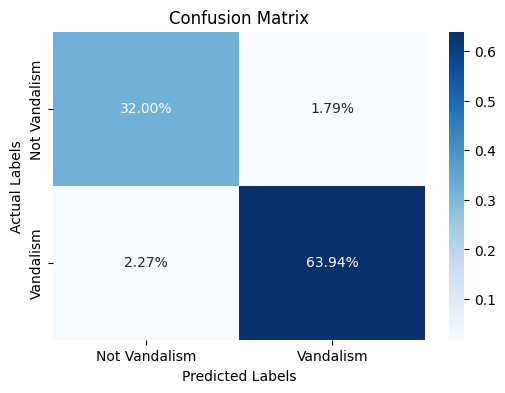

In [109]:
from evaluate_xgboost_model import (
    evaluate_train_test_metrics,
    calculate_auc_scores,
    plot_confusion_matrix
)

# Evaluate Train and Test Metrics
y_test_pred, y_test_prob = evaluate_train_test_metrics(
    final_base_model, X_train, y_train, X_test, y_test
)

# Calculate AUC Scores and Get Confusion Matrix for the Test Set
cm = calculate_auc_scores(y_test, y_test_pred, y_test_prob)

# Plot Confusion Matrix
plot_confusion_matrix(cm)

### Hyperparameter tuning with cross validation and model training with best parameters

In [110]:
from model.hyper_parameter_search import randomized_search_cv
from model.xgboost_training import train_final_model, save_model
from model.evaluate_xgboost_model import evaluate_model_with_cv

# Generate random hyperparameters or load from a saved file
best_params = randomized_search_cv(
    X_train, y_train, '../saved_parameters/contribution_model/best_hyperparameters.json'
)

# Train Final Model with best_params using training and validation sets
final_tuned_model = train_final_model(
    X_train, y_train, X_val, y_val, best_params
)

# (OPTIONAL): Perform Cross-Validation on Training Data
cv_scores = evaluate_model_with_cv(
    X_train, y_train, best_params
)

# Save the Model
save_model(
    final_tuned_model, '../saved_parameters/contribution_model/final_xgboost_model_tuned.pkl'
)


2024-11-16 21:08:12 - INFO - hyper_parameter_search.py -- Hyperparameters file already exists.

2024-11-16 21:08:12 - INFO - load_hyper_parameters.py -- Loaded hyperparameters from ../saved_parameters/contribution_model/best_hyperparameters.json

2024-11-16 21:08:12 - INFO - hyper_parameter_search.py -- best hyper parameters: {'subsample': 0.9, 'n_estimators': 100, 'min_child_weight': 5, 'max_depth': 9, 'learning_rate': 0.3, 'lambda': 0, 'gamma': 2, 'colsample_bytree': 0.7, 'alpha': 0}

2024-11-16 21:08:15 - INFO - xgboost_training.py -- Model training complete.

2024-11-16 21:08:15 - INFO - xgboost_training.py -- Best iteration: 100

2024-11-16 21:08:15 - INFO - xgboost_training.py -- Best score (on validation set): 0.9999

2024-11-16 21:08:15 - INFO - xgboost_training.py -- No early stopping. Model trained for all 100 iterations.



Performing 5-fold Cross-Validation on the training data...



2024-11-16 21:08:23 - INFO - xgboost_training.py -- Model saved to ../saved_parameters/contribution_model/final_xgboost_model_tuned.pkl


Cross-Validation AUC Scores: [0.99987476 0.9998781  0.9998899  0.99985619 0.99983272]
Mean AUC Score: 0.99986633504914
Standard Deviation of AUC Scores: 1.998808224499561e-05


### Tuned model evaluation


Train Set Evaluation
--------------------

Accuracy: 0.9977053401381052
AUC-ROC: 0.9999475200736144

Classification Report (Train):
                precision    recall  f1-score   support

Not Vandalism       1.00      1.00      1.00     95256
    Vandalism       1.00      1.00      1.00    186703

     accuracy                           1.00    281959
    macro avg       1.00      1.00      1.00    281959
 weighted avg       1.00      1.00      1.00    281959


Test Set Evaluation
-------------------

Accuracy: 0.9952187472984925
AUC-ROC: 0.9997806236896897

Classification Report (Test):
                precision    recall  f1-score   support

Not Vandalism       0.99      1.00      0.99     50803
    Vandalism       1.00      1.00      1.00     99576

     accuracy                           1.00    150379
    macro avg       0.99      1.00      0.99    150379
 weighted avg       1.00      1.00      1.00    150379


AUC-PR Score on Test Set: 0.9998942848890178
ROC-AUC Score on Test S

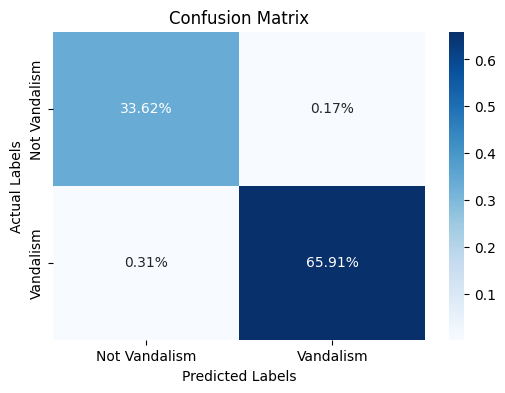

In [111]:
from evaluate_xgboost_model import (
    evaluate_train_test_metrics,
    calculate_auc_scores,
    plot_confusion_matrix
)

# Evaluate Train and Test Metrics
y_test_pred, y_test_prob = evaluate_train_test_metrics(
    final_tuned_model, X_train, y_train, X_test, y_test
)

# Calculate AUC Scores and Get Confusion Matrix for the Test Set
cm = calculate_auc_scores(y_test, y_test_pred, y_test_prob)

# Plot Confusion Matrix
plot_confusion_matrix(cm)

In [112]:
from sklearn.metrics import matthews_corrcoef

mcc = matthews_corrcoef(y_test, y_test_pred)
print(f"Matthews Correlation Coefficient: {mcc:.4f}")


Matthews Correlation Coefficient: 0.9893


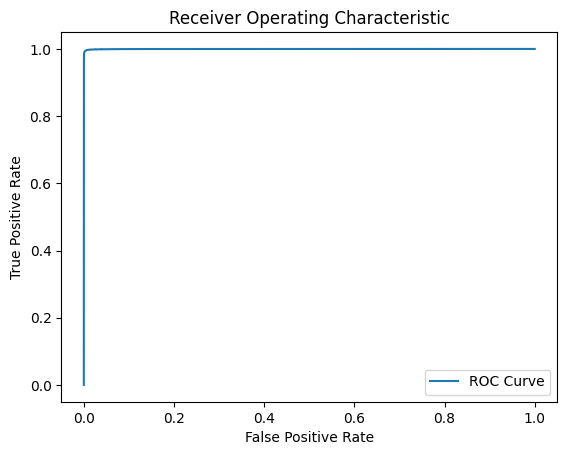

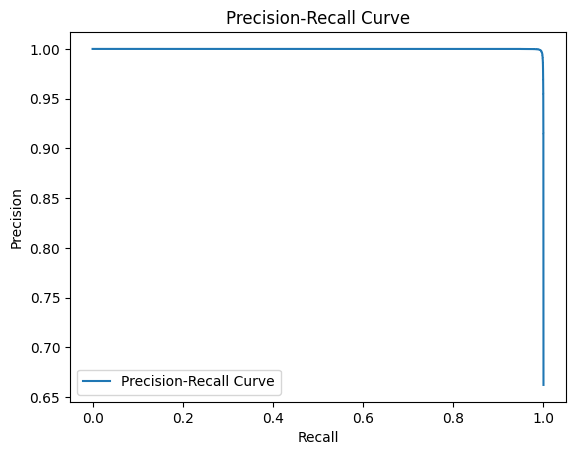

In [113]:
from model.evaluate_xgboost_model import plot_roc_pr_curves

plot_roc_pr_curves(y_test, y_test_prob)

In [114]:
### Bootstrapping

In [115]:
from evaluate_data_set.bootstrap_evaluation import (
    perform_bootstrap_evaluation,
    calculate_bootstrap_statistics,
    plot_metric_distributions,
    compute_additional_statistics,
    save_bootstrap_results
)

In [116]:
# Assuming you have your trained model and test data
if not os.path.exists('../saved_parameters/contribution_model/bootstrapping/bootstrap_test_set_metrics_all_iterations.csv'):
    metrics_df = perform_bootstrap_evaluation(
        model=final_base_model,
        X_test=X_test,
        y_test=y_test,
        n_iterations=1000,
        random_state=42  # Optional for reproducibility
    )

In [117]:
if not os.path.exists('../saved_parameters/contribution_model/bootstrapping/bootstrap_test_set_metrics_all_iterations.csv'):
    results_df = calculate_bootstrap_statistics(metrics_df)
    print("Bootstrap Performance Metrics on Test Set:")
    print(results_df)

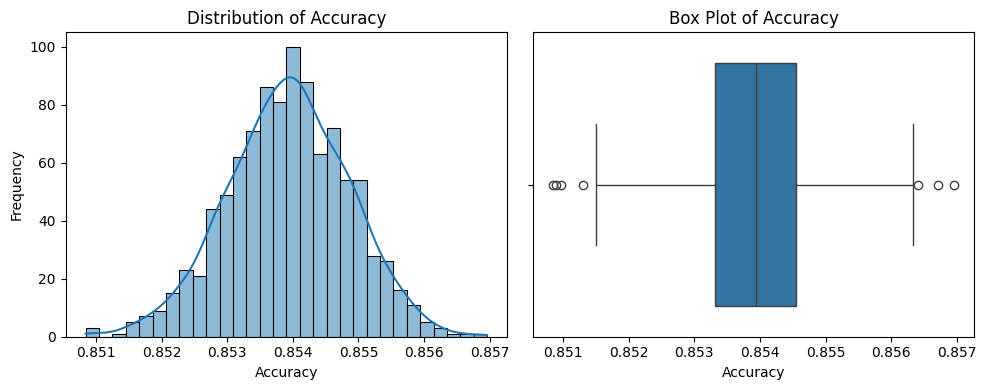

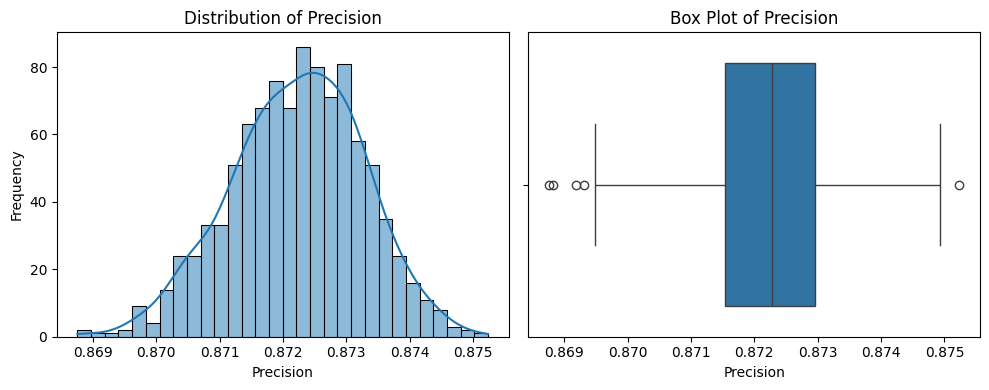

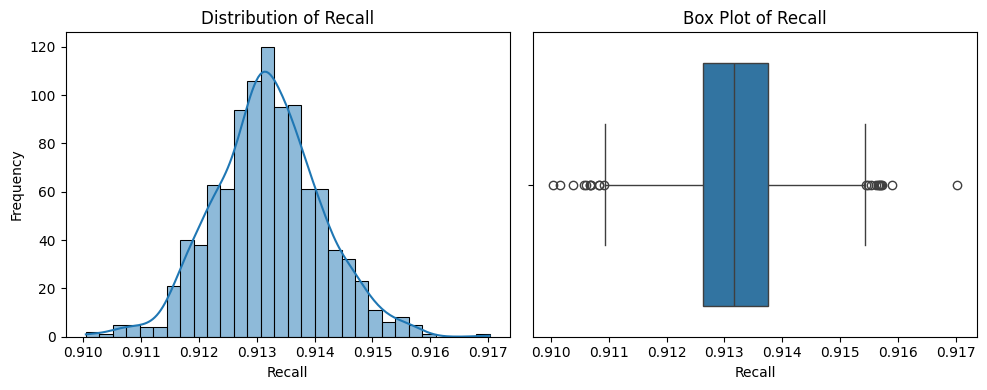

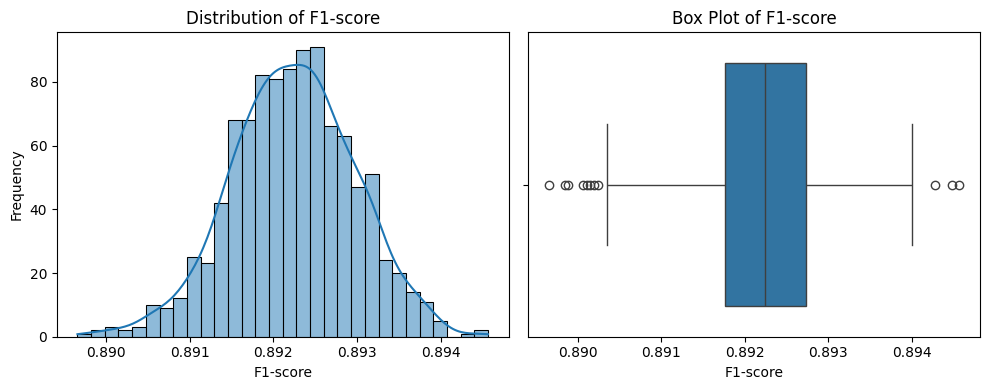

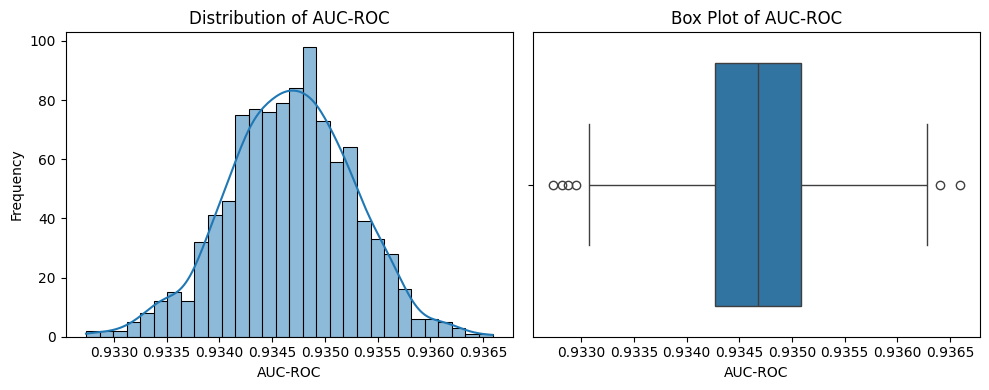

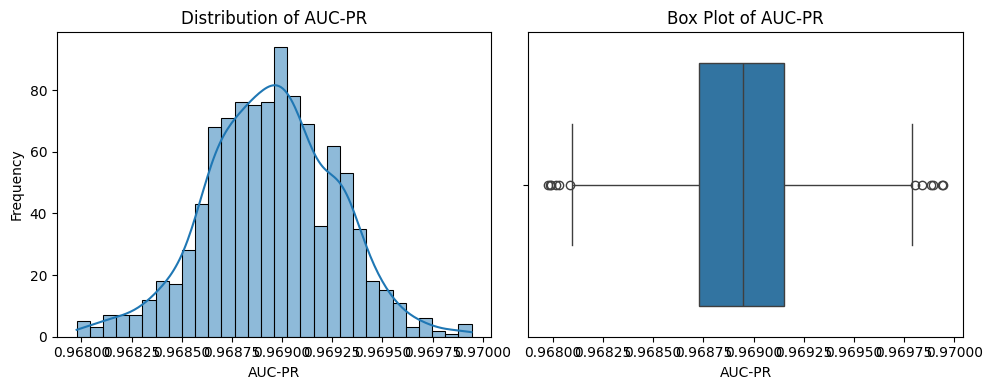

In [118]:
plot_metric_distributions(metrics_df)

In [119]:
stats_df = compute_additional_statistics(metrics_df)
print("Additional Statistics for Each Metric:")
print(stats_df)

Additional Statistics for Each Metric:
      Metric  Skewness  Kurtosis Normal Distribution  Normality p-value
0   Accuracy -0.106579  0.078172                 Yes           0.320324
1  Precision -0.201476 -0.127241                  No           0.025629
2     Recall  0.072361  0.443096                  No           0.028055
3   F1-score -0.120027  0.137190                 Yes           0.189388
4    AUC-ROC -0.081626  0.082107                 Yes           0.467942
5     AUC-PR -0.063562  0.191341                 Yes           0.322883


In [120]:
folder_to_save_bootstrap_results = '../saved_parameters/contribution_model/bootstrapping'
save_bootstrap_results(metrics_df, results_df, stats_df, folder_to_save_bootstrap_results, prefix='bootstrap_test_set')


2024-11-16 21:08:29 - INFO - bootstrap_evaluation.py -- Directory already exists at: ../saved_parameters/contribution_model/bootstrapping

2024-11-16 21:08:29 - INFO - bootstrap_evaluation.py -- Results saved in saved_parameters with prefix "../saved_parameters/contribution_model/bootstrapping/bootstrap_test_set"


### Continent Evaluation

In [121]:
# Import necessary libraries and the module
import pandas as pd
import evaluate_data_set.continent_evaluation as ce

# Ensure X_test and y_test are defined and include bounding box fields
# If necessary, load your test data here

# Convert X_test to DataFrame if it's not already
if not isinstance(X_test, pd.DataFrame):
    X_test = pd.DataFrame(X_test, columns=final_base_model.get_booster().feature_names)

# Step 1: Calculate center coordinates
X_test = ce.calculate_center_coordinates(X_test, xmin_col='xmin', xmax_col='xmax', ymin_col='ymin', ymax_col='ymax')

# Step 2: Assign continents
X_test = ce.assign_continents(X_test)

# Step 3: Split test set by continent
continent_data = ce.split_test_set_by_continent(X_test, y_test)

# Step 4: Evaluate model on each continent
results = ce.evaluate_model_on_continents(continent_data, final_tuned_model)

In [122]:
# Convert results to DataFrame
import pandas as pd

stats_columns = [
    'Total Samples', 'Total Correct Predictions', 'True Positives (TP)',
    'True Negatives (TN)', 'False Positives (FP)', 'False Negatives (FN)',
    'Accuracy', 'Precision', 'Recall', 'F1-score', 'AUC-ROC', 'AUC-PR'
]

stats_df = pd.DataFrame.from_dict(results, orient='index')[stats_columns]
stats_df.index.name = 'Continent Name'
stats_df.reset_index(inplace=True)

# Display the statistics table
print("\nStatistics Table for Each Continent:")
display(stats_df)



Statistics Table for Each Continent:


,Continent Name,Total Samples,Total Correct Predictions,True Positives (TP),True Negatives (TN),False Positives (FP),False Negatives (FN),Accuracy,Precision,Recall,F1-score,AUC-ROC,AUC-PR
0,Europe,51967,51640,33165,18475,109,218,0.993708,0.996724,0.993470,0.995094,0.999721,0.999856
1,North America,26717,26566,17916,8650,66,85,0.994348,0.996330,0.995278,0.995804,0.999701,0.999857
2,Africa,20792,20740,14356,6384,8,44,0.997499,0.999443,0.996944,0.998192,0.999913,0.999963
3,Asia,23790,23677,12299,11378,34,79,0.995250,0.997243,0.993618,0.995427,0.999662,0.999732
4,Other,12991,12966,10070,2896,11,14,0.998076,0.998909,0.998612,0.998760,0.999947,0.999985
5,Oceania,4874,4856,3851,1005,10,8,0.996307,0.997410,0.997927,0.997668,0.999674,0.999904
6,South America,9224,9191,7441,1750,15,18,0.996422,0.997988,0.997587,0.997787,0.999892,0.999975
7,Antarctica,24,24,12,12,0,0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
